# Import Packages

### What is TensorFlow used for?
It is an open source artificial intelligence library, using data flow graphs to build models. It allows developers to create large-scale neural networks with many layers. TensorFlow is mainly used for: Classification, Perception, Understanding, Discovering, Prediction and Creation.

### Density-Based Clustering Algorithms

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a base algorithm for density-based clustering. It can discover clusters of different shapes and sizes from a large amount of data, which is containing noise and outliers.
Good for data which contains clusters of similar density. 

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing, utils, losses, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Embedding, SpatialDropout1D

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from pickle import dump, load
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot, cm

import datetime
from geopy.geocoders import Nominatim
pd.options.display.float_format = "{:,.2f}".format

import warnings 
warnings.filterwarnings('ignore')

# Load Data & Process

In [30]:
# load data
weather_dataframe = pd.read_csv('weather_data.csv')

In [31]:
def min_max_scale(vals):
    min_val = min(vals)
    max_val = max(vals)
    scaled_vals = []
    for val in vals:
        val = val[0]
        scaled_val = ((val - min_val) / (max_val - min_val))[0]
        scaled_vals.append(scaled_val)
    return scaled_vals

In [32]:
# generate rainfall percentage using min-max scaling
rainfall_percentage = []

for val in min_max_scale(weather_dataframe[['Rainfall']].values):
    rainfall_percentage.append(round(val * 100))
    
weather_dataframe['Rainfall Percentage'] = rainfall_percentage

weather_dataframe.sample(7)

,Station Names,Year,Month,Latitude,Longitude,Max Temp,Min Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Rainfall Percentage
7731,Faridpur,1969,12,23.61,89.84,27.20,13.40,5.00,78.00,0.70,0.90,7.23,0.00
16241,Rangpur,1959,4,25.72,89.26,36.80,22.60,102.00,73.00,1.81,2.70,7.17,5.00
14056,Mymensingh,1988,9,24.75,90.41,35.30,26.20,309.00,85.00,1.50,5.20,4.50,15.00
15050,Rajshahi,1992,6,24.35,88.56,39.60,25.70,85.00,78.00,2.10,4.50,6.80,4.00
4088,Comilla,1962,4,23.48,91.19,36.90,23.50,189.00,75.00,3.00,4.50,7.79,9.00
16534,Rangpur,2012,8,25.72,89.26,35.20,26.80,187.00,81.00,2.00,6.40,6.70,9.00
8781,Hatiya,1999,11,22.29,91.13,30.50,21.10,1.00,82.00,0.60,0.50,9.80,0.00


In [33]:
weather_dataframe.info()
weather_dataframe.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21120 entries, 0 to 21119
Data columns (total 13 columns):
Station Names          21120 non-null object
Year                   21120 non-null int64
Month                  21120 non-null int64
Latitude               21120 non-null float64
Longitude              21120 non-null float64
Max Temp               21120 non-null float64
Min Temp               21120 non-null float64
Rainfall               21120 non-null float64
Relative Humidity      21120 non-null float64
Wind Speed             21120 non-null float64
Cloud Coverage         21120 non-null float64
Bright Sunshine        21120 non-null float64
Rainfall Percentage    21120 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 2.1+ MB


,count,mean,std,min,25%,50%,75%,max
Year,"21,120.00","1,985.77",17.60,"1,948.00","1,972.00","1,988.00","2,001.00","2,013.00"
Month,"21,120.00",6.50,3.45,1.00,3.75,6.50,9.25,12.00
Latitude,"21,120.00",23.36,1.17,20.87,22.64,23.17,24.29,25.75
Longitude,"21,120.00",90.45,1.13,88.56,89.36,90.39,91.46,92.26
Max Temp,"21,120.00",33.48,2.99,21.60,31.70,33.90,35.50,44.00
Min Temp,"21,120.00",21.15,4.97,6.20,16.90,23.40,25.40,28.10
Rainfall,"21,120.00",197.53,239.04,0.00,8.00,110.00,310.00,"2,072.00"
Relative Humidity,"21,120.00",79.46,7.66,34.00,75.00,81.00,85.00,97.00
Wind Speed,"21,120.00",1.42,1.04,0.00,0.70,1.20,1.90,11.20
Cloud Coverage,"21,120.00",3.48,2.08,0.00,1.50,3.30,5.50,7.90


## Outlier Detaction

Total Outliers: 1


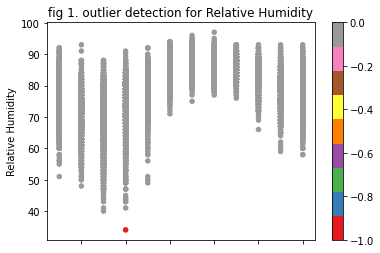

In [34]:
# outlier detection for "Relative Humidity"

outlier_detection = DBSCAN(
    metric='euclidean',        # euclidean method for distance calculation
    eps=5,                     # maximum distance between two samples for one to be considered as in the neighborhood 
    min_samples=10             # number of samples in a neighborhood for a point to be considered as a core point
)
clusters = outlier_detection.fit_predict(weather_dataframe[['Relative Humidity']])

#weather_dataframe.plot.scatter(x='Month', y='Relative Humidity',c=clusters, cmap=cm.get_cmap('Set1'), colorbar=True)

# clean outliers
outlier_indexes = []
for i in range(0, len(clusters)):
    if clusters[i] != 0: outlier_indexes.append(i)

weather_dataframe = weather_dataframe.drop(outlier_indexes)

#print('Total Outliers: ' + str(len(outlier_indexes)))

Total Outliers: 11


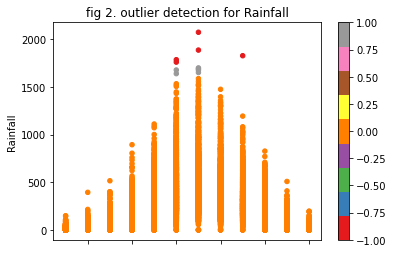

In [35]:
# outlier detection for "Rainfall"

outlier_detection = DBSCAN(
    metric='euclidean',             # euclidean method for distance calculation
    eps=50,                         # maximum distance between two samples for one to be considered as in the neighborhood 
    min_samples=5                   # number of samples in a neighborhood for a point to be considered as a core point
)
clusters = outlier_detection.fit_predict(weather_dataframe[['Rainfall']])

#weather_dataframe.plot.scatter(x='Month', y='Rainfall', c=clusters, cmap=cm.get_cmap('Set1'), colorbar=True)

# clean outliers
outlier_indexes = []
for i in range(0, len(clusters)):
    if clusters[i] != 0: outlier_indexes.append(i)
        
weather_dataframe = weather_dataframe.drop(outlier_indexes)

#print('Total Outliers: ' + str(len(outlier_indexes)))

# Define Test and Train Data

In [36]:
# separate x and y data
X = np.array(weather_dataframe[['Latitude', 'Longitude', 'Year', 'Month']].values)

Y = np.array(weather_dataframe[['Min Temp', 'Max Temp', 'Rainfall', 'Relative Humidity',
                                'Wind Speed', 'Cloud Coverage', 'Bright Sunshine', 'Rainfall Percentage']].values)

input_dim = X.shape[1]
output_dim = Y.shape[1]


# split train and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# Deep Learning Algorithms

### EarlyStopping

In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration.

In [37]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=30)

In [38]:
# define and compile the model
model = Sequential()
model.add(Dense(100, input_dim=input_dim, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(output_dim))
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 208       
Total params: 7,033
Trainable params: 7,033
Non-trainable params: 0
_________________________________________________________________


In [40]:
# fit the model
#history = model.fit(x_train, y_train, batch_size=30, epochs=300, callbacks=[early_stop], validation_split = 0.3)

Train on 9899 samples, validate on 4243 samples
Epoch 1/300
9899/9899 [==============================] - 4s 366us/sample - loss: 9078.8670 - acc: 0.5256 - val_loss: 6736.7781 - val_acc: 0.5581
Epoch 2/300
9899/9899 [==============================] - 1s 126us/sample - loss: 7348.0657 - acc: 0.5522 - val_loss: 6757.4727 - val_acc: 0.5581
Epoch 3/300
9899/9899 [==============================] - 1s 129us/sample - loss: 7344.3327 - acc: 0.5522 - val_loss: 6760.0499 - val_acc: 0.5581
Epoch 4/300
9899/9899 [==============================] - 1s 128us/sample - loss: 7343.0490 - acc: 0.5522 - val_loss: 6709.3437 - val_acc: 0.5581
Epoch 5/300
9899/9899 [==============================] - 1s 126us/sample - loss: 7344.6699 - acc: 0.5522 - val_loss: 6735.0340 - val_acc: 0.5581
Epoch 6/300
9899/9899 [==============================] - 1s 133us/sample - loss: 7335.1500 - acc: 0.5522 - val_loss: 6707.9383 - val_acc: 0.5581
Epoch 7/300
9899/9899 [==============================] - 1s 149us/sample - loss: 7

Epoch 57/300
9899/9899 [==============================] - 2s 180us/sample - loss: 3344.4645 - acc: 0.8628 - val_loss: 2885.5762 - val_acc: 0.8906
Epoch 58/300
9899/9899 [==============================] - 2s 169us/sample - loss: 3331.7935 - acc: 0.8669 - val_loss: 3322.5343 - val_acc: 0.8680
Epoch 59/300
9899/9899 [==============================] - 2s 212us/sample - loss: 3337.2302 - acc: 0.8599 - val_loss: 3006.2358 - val_acc: 0.8294
Epoch 60/300
9899/9899 [==============================] - 3s 312us/sample - loss: 3316.1604 - acc: 0.8619 - val_loss: 2844.7148 - val_acc: 0.8364
Epoch 61/300
9899/9899 [==============================] - 2s 185us/sample - loss: 3324.8038 - acc: 0.8608 - val_loss: 2838.6021 - val_acc: 0.8572
Epoch 62/300
9899/9899 [==============================] - 2s 155us/sample - loss: 3308.8500 - acc: 0.8619 - val_loss: 3266.2877 - val_acc: 0.8480
Epoch 63/300
9899/9899 [==============================] - 2s 181us/sample - loss: 3287.8013 - acc: 0.8637 - val_loss: 2850.8

9899/9899 [==============================] - 2s 185us/sample - loss: 3231.5679 - acc: 0.8782 - val_loss: 2653.1261 - val_acc: 0.8906
Epoch 114/300
9899/9899 [==============================] - 1s 151us/sample - loss: 3148.9283 - acc: 0.8852 - val_loss: 2942.0520 - val_acc: 0.8798
Epoch 115/300
9899/9899 [==============================] - 2s 174us/sample - loss: 3201.9848 - acc: 0.8815 - val_loss: 2727.4384 - val_acc: 0.8699
Epoch 116/300
9899/9899 [==============================] - 2s 226us/sample - loss: 3180.6583 - acc: 0.8867 - val_loss: 2727.1997 - val_acc: 0.8852
Epoch 117/300
9899/9899 [==============================] - 2s 248us/sample - loss: 3150.1629 - acc: 0.8890 - val_loss: 2649.2928 - val_acc: 0.8902
Epoch 118/300
9899/9899 [==============================] - 1s 144us/sample - loss: 3183.6574 - acc: 0.8834 - val_loss: 2751.2182 - val_acc: 0.8850
Epoch 119/300
9899/9899 [==============================] - 1s 144us/sample - loss: 3182.9314 - acc: 0.8818 - val_loss: 2852.1331 - v

Epoch 169/300
9899/9899 [==============================] - 2s 166us/sample - loss: 3022.7406 - acc: 0.8817 - val_loss: 2755.4426 - val_acc: 0.8631
Epoch 170/300
9899/9899 [==============================] - 2s 167us/sample - loss: 3026.4036 - acc: 0.8821 - val_loss: 2514.7038 - val_acc: 0.8836
Epoch 171/300
9899/9899 [==============================] - 2s 171us/sample - loss: 2966.5852 - acc: 0.8877 - val_loss: 2492.8943 - val_acc: 0.8899
Epoch 172/300
9899/9899 [==============================] - 2s 215us/sample - loss: 2965.8852 - acc: 0.8837 - val_loss: 2455.6307 - val_acc: 0.8888
Epoch 173/300
9899/9899 [==============================] - 3s 276us/sample - loss: 2976.3000 - acc: 0.8838 - val_loss: 2747.0094 - val_acc: 0.8777
Epoch 174/300
9899/9899 [==============================] - 2s 169us/sample - loss: 3020.4116 - acc: 0.8825 - val_loss: 2718.9032 - val_acc: 0.8909
Epoch 175/300
9899/9899 [==============================] - 2s 170us/sample - loss: 2951.7337 - acc: 0.8781 - val_loss:

Epoch 225/300
9899/9899 [==============================] - 3s 270us/sample - loss: 2888.2310 - acc: 0.8809 - val_loss: 2682.4459 - val_acc: 0.8482
Epoch 226/300
9899/9899 [==============================] - 2s 207us/sample - loss: 2985.1266 - acc: 0.8799 - val_loss: 2411.0361 - val_acc: 0.8784
Epoch 227/300
9899/9899 [==============================] - 3s 284us/sample - loss: 2774.3327 - acc: 0.8854 - val_loss: 2399.0229 - val_acc: 0.8805
Epoch 228/300
9899/9899 [==============================] - 2s 185us/sample - loss: 2806.0096 - acc: 0.8848 - val_loss: 2380.1753 - val_acc: 0.8888
Epoch 229/300
9899/9899 [==============================] - 2s 186us/sample - loss: 2878.9709 - acc: 0.8824 - val_loss: 2374.0983 - val_acc: 0.8885
Epoch 230/300
9899/9899 [==============================] - 2s 168us/sample - loss: 2902.1925 - acc: 0.8761 - val_loss: 2685.2719 - val_acc: 0.8442
Epoch 231/300
9899/9899 [==============================] - 2s 168us/sample - loss: 2756.1264 - acc: 0.8872 - val_loss:

Epoch 281/300
9899/9899 [==============================] - 3s 330us/sample - loss: 2825.1316 - acc: 0.8796 - val_loss: 2267.4464 - val_acc: 0.8888
Epoch 282/300
9899/9899 [==============================] - 1s 146us/sample - loss: 2739.8096 - acc: 0.8853 - val_loss: 2425.3467 - val_acc: 0.8866
Epoch 283/300
9899/9899 [==============================] - 1s 148us/sample - loss: 2900.0656 - acc: 0.8760 - val_loss: 2422.0562 - val_acc: 0.8822
Epoch 284/300
9899/9899 [==============================] - 1s 149us/sample - loss: 2872.1924 - acc: 0.8814 - val_loss: 2565.5255 - val_acc: 0.8902
Epoch 285/300
9899/9899 [==============================] - 2s 153us/sample - loss: 2778.9187 - acc: 0.8816 - val_loss: 2244.5516 - val_acc: 0.8888
Epoch 286/300
9899/9899 [==============================] - 2s 161us/sample - loss: 2819.0953 - acc: 0.8804 - val_loss: 2279.1613 - val_acc: 0.8899
Epoch 287/300
9899/9899 [==============================] - 2s 180us/sample - loss: 2814.4534 - acc: 0.8869 - val_loss:

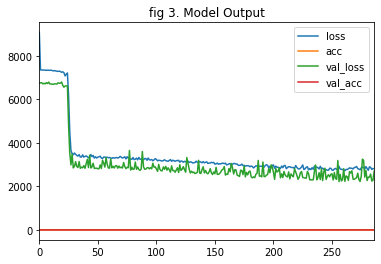

In [41]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot(title = 'fig 1. Model Output')

In [42]:
# save the trained model
model.save('model.h5')

# Load the Saved Model and Test

In [43]:
# load the model
model = keras.models.load_model('model.h5')

# bulk prediction
test_dataframe = []
for i in range(0, 20):
    test_x = x_test[i]
    test_y = y_test[i]
    pred_y = model.predict(np.array([test_x]))[0]
    test_dataframe.append([
        str(round(test_x[0], 2)), str(round(test_x[1], 2)), int(test_x[2]), int(test_x[3]),
        str(round(test_y[0], 1)), str(round(pred_y[0], 1)), str(round(test_y[1], 1)), str(round(pred_y[1], 1)),
        str(round(test_y[2], 1)), str(round(pred_y[2], 1)), str(round(test_y[3], 1)), str(round(pred_y[3], 1)),
        str(round(test_y[4], 1)), str(round(pred_y[4], 1)), str(round(test_y[5], 1)), str(round(pred_y[5], 1)),
        str(round(test_y[6], 1)), str(round(pred_y[6], 1)), str(round(test_y[7], 1)), str(round(pred_y[7], 1))
    ])

test_dataframe = pd.DataFrame(test_dataframe)
test_dataframe.columns = [
    'Latitude', 'Longitude', 'Year', 'Month', 'Min Temp', 'Min Temp (Predicted)', 'Max Temp', 'Max Temp (Predicted)',
    'Rainfall', 'Rainfall (Predicted)', 'Relative Humidity', 'Relative Humidity (Predicted)',
    'Wind Speed', 'Wind Speed (Predicted)', 'Cloud Coverage', 'Cloud Coverage (Predicted)',
    'Bright Sunshine', 'Bright Sunshine (Predicted)', 'Rainfall Percentage', 'Rainfall Percentage (Predicted)'
]

def dataframe_style(data):
    return ['background-color: yellow;' for i in data]

test_dataframe.style.apply(dataframe_style, axis=0, subset=[
    'Max Temp (Predicted)', 'Min Temp (Predicted)','Relative Humidity (Predicted)', 'Rainfall (Predicted)',
    'Cloud Coverage (Predicted)', 'Wind Speed (Predicted)','Bright Sunshine (Predicted)', 'Rainfall Percentage (Predicted)'
])

,Latitude,Longitude,Year,Month,Min Temp,Min Temp (Predicted),Max Temp,Max Temp (Predicted),Rainfall,Rainfall (Predicted),Relative Humidity,Relative Humidity (Predicted),Wind Speed,Wind Speed (Predicted),Cloud Coverage,Cloud Coverage (Predicted),Bright Sunshine,Bright Sunshine (Predicted),Rainfall Percentage,Rainfall Percentage (Predicted)
0,25.75,88.92,1994,11,17.1,16.8,31.8,32.1,7.6,23.5,67.0,83.4,1.5,0.2,2.0,1.5,7.2,6.4,0.0,1.4
1,23.61,89.84,2002,1,13.7,13.9,27.5,31.4,19.0,22.1,78.0,75.8,0.4,1.7,1.3,1.2,7.6,7.5,1.0,0.1
2,22.83,91.08,1994,4,23.7,20.7,36.4,35.6,430.0,98.0,74.0,73.9,1.4,2.2,3.1,2.8,7.5,7.7,21.0,3.5
3,24.29,91.73,1965,6,24.3,24.3,36.1,34.0,845.0,373.4,86.0,80.0,0.8,1.8,4.3,5.6,4.3,4.5,41.0,16.1
4,23.48,91.19,1966,12,14.2,17.1,27.8,32.4,58.0,3.8,86.0,85.0,0.1,0.1,1.4,1.2,7.0,7.4,3.0,0.3
5,22.64,91.64,1992,10,23.6,25.7,34.5,36.3,480.0,163.5,83.0,86.9,0.5,0.6,3.8,3.9,5.4,6.4,23.0,7.1
6,22.68,89.07,2003,12,14.1,16.8,28.5,32.4,25.0,5.6,81.0,85.1,0.2,0.1,1.4,1.2,6.7,7.1,1.0,0.5
7,24.12,89.04,1981,5,23.7,22.6,39.0,34.9,323.0,225.3,77.0,73.5,2.4,2.0,4.9,4.4,7.3,6.1,16.0,9.8
8,22.34,91.79,2003,6,25.0,25.3,34.8,36.0,1209.0,391.0,90.0,87.7,1.2,2.0,6.7,5.6,4.2,4.5,58.0,18.2
9,23.65,88.82,2009,7,26.2,24.5,35.5,33.7,366.9,395.8,87.4,82.3,1.2,1.8,5.8,6.4,4.3,4.3,18.0,16.8


In [44]:
y_pred = model.predict(x_test)
print("Explain variance score =", metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score =", metrics.r2_score(y_test, y_pred))

Explain variance score = 0.4872351725973381
R2 score = 0.4758937008920575


# Load the Location and Forecast Weather of Next 12 Months

In [45]:
#Dehradun ----
current_position = {'latitude': 30.45,'longitude': 78.1002}

#Dhaka ----
#current_position = {'latitude': 23.8103,'longitude': 90.4125}

In [47]:
# bulk prediction
result_dataframe = []
for i in range(0, 12):
    month = datetime.datetime.now().month + i
    year = datetime.datetime.now().year
    if month > 12:
        month = month - 12
        year = year + 1
        
    pred = model.predict(np.array([[current_position['latitude'],current_position['longitude'],year,month]]))[0]
    result_dataframe.append([str(month) + '/' + str(year), pred[0], pred[1], pred[2], pred[3], pred[4], pred[5], pred[6], pred[7]])
    
result_dataframe = pd.DataFrame(result_dataframe)
result_dataframe.columns = ['Month','Min Temp','Max Temp','Rainfall','Relative Humidity',
                            'Wind Speed','Cloud Coverage','Bright Sunshine','Rainfall Percenatge']

location = Nominatim(user_agent="Weather Forecasting").reverse(str(current_position['latitude']) + ', ' + str(current_position['longitude']))

print('Weather Forecasting for:\nLocation: ' + location.address + '\nLatitude: ' + str(current_position['latitude']) + '\nLongitude: ' + str(current_position['longitude']))
result_dataframe

Weather Forecasting for:
Location: Lane 11 West, বারিধারা, ঢাকা, Chanpara Bazar, ঢাকা জেলা, ঢাকা বিভাগ, 1230, বাংলাদেশ
Latitude: 23.8103
Longitude: 90.4125


,Month,Min Temp,Max Temp,Rainfall,Relative Humidity,Wind Speed,Cloud Coverage,Bright Sunshine,Rainfall Percenatge
0,6/2021,23.52,33.39,343.00,76.88,1.73,5.44,4.99,14.13
1,7/2021,25.41,34.54,406.39,84.12,1.86,6.47,4.30,17.67
2,8/2021,25.75,35.28,345.34,86.35,1.53,5.97,4.72,14.85
3,9/2021,28.20,37.97,287.55,91.19,1.18,5.65,5.18,12.46
4,10/2021,24.10,35.63,144.51,86.28,0.56,3.58,6.06,6.42
5,11/2021,19.13,32.93,39.56,83.18,0.24,1.97,6.68,1.93
6,12/2021,16.76,32.62,6.64,85.96,0.12,1.20,7.10,0.56
7,1/2022,13.95,31.65,22.32,76.49,1.68,1.17,7.54,0.12
8,2/2022,14.26,30.98,22.79,73.48,1.66,1.26,7.28,0.24
9,3/2022,15.18,31.06,43.07,70.88,1.76,1.64,7.23,1.16


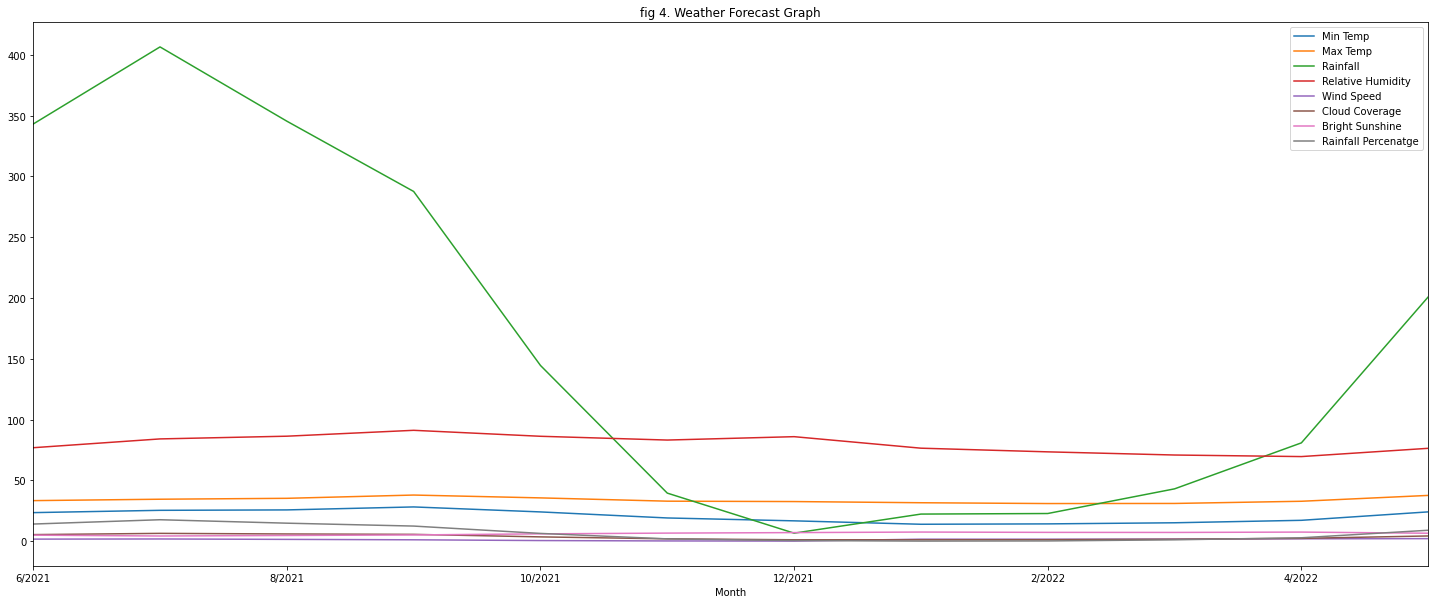

In [48]:
pyplot.figure(figsize=(25,10))

# plot data
ax = pyplot.gca(title = 'fig 2. Weather Forecast Graph')
result_dataframe.plot(kind='line', x='Month', y='Min Temp', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Max Temp', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Rainfall', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Relative Humidity', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Wind Speed', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Cloud Coverage', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Bright Sunshine', ax=ax)
result_dataframe.plot(kind='line', x='Month', y='Rainfall Percenatge', ax=ax)

pyplot.show()

In [49]:
fig = px.line(result_dataframe,x='Month', y='Min Temp', title = 'fig 3. Minimum Temperature for next year')
fig.show()

In [50]:
fig = px.bar(result_dataframe,x='Month', y='Max Temp', title = 'fig 4. Maximum Temperature for next year')
fig.show()

In [51]:
fig = px.scatter(result_dataframe,x='Month', y='Rainfall', title = 'fig 5. Rainfall for next year')
fig.show()

In [52]:
fig = px.histogram(result_dataframe,x='Month', y='Relative Humidity', title = 'fig 6. Relative Humidity for next year')
fig.show()

In [53]:
fig = px.line(result_dataframe, x='Month', y='Wind Speed', title = 'fig 7. Wind Speed for next year')
fig.show()

In [54]:
fig = px.bar(result_dataframe,x='Month', y='Cloud Coverage', title = 'fig 8. Cloud Coverage for next year')
fig.show()

In [55]:
fig = px.line(result_dataframe,x='Month', y='Bright Sunshine', title = 'fig 9. Sunshine for next year')
fig.show()

In [57]:
fig = px.bar(result_dataframe,x='Month', y='Rainfall Percenatge', title = 'fig 10. Overall Rainfall % for next year')
fig.show()

# THANK YOU